# 2D Burgers - Sympy implementation

*Last edited: 2024-02-20*  
*Created: 2023-06-26*

Burgers' equation can be used to describe various types of phenomena, such as turbulence, and flow through a shock wave traveling in a viscous fluid (Bahadır, 2003). This Notebook shows an implementation of two-dimensional Burgers equations that are discretized using the fully implicit finite difference method, which results in a system of nonlinear difference equations that is solved at each time step. The two-dimensional system of Burgers equations used in this work comes from the work of Kweyu et al. (2012):

$$
\frac{\partial u}{\partial t} +
u \frac{\partial u}{\partial x} +
v \frac{\partial u}{\partial y} =
\frac{1}{\mathsf{Re}}
\left(
\frac{\partial^{2} u}{\partial x^{2}} + 
\frac{\partial^{2} u}{\partial y^{2}}
\right) \ \ ,
$$

$$
\frac{\partial v}{\partial t} +
u \frac{\partial v}{\partial x} +
v \frac{\partial v}{\partial y} =
\frac{1}{\mathsf{Re}}
\left(
\frac{\partial^{2} v}{\partial x^{2}} + 
\frac{\partial^{2} v}{\partial y^{2}}
\right)
$$

subject to the initial conditions:

$$
\left.
\begin{array}{r} 
u(x,y,0) = \varphi_1 (x,y) \\
v(x,y,0) = \varphi_2 (x,y)
\end{array}
\right\}
(x,y) \in \Omega
$$

and Dirichlet boundary conditions:

$$
\left.
\begin{array}{r} 
u(x,y,t) = \zeta (x,y,t) \\
v(x,y,t) = \xi (x,y,t)
\end{array}
\right\}
(x,y) \in \partial \Omega \ , \ \ t > 0
$$

where $\Omega$ is the computational domain:

$$
\Omega = \{ (x,y): a \le x \le b \ , \ a \le y \le b \}
$$

and:

- $\partial\Omega$ is the boundary
- $u(x,y,t)$ and $v(x,y,t)$ are the velocity components to be determined
- $\varphi_1$, $\varphi_2$, $\zeta$ and $\xi$ are know functions
- $\frac{\partial u}{\partial t}$ is the unsteady term
- $u \frac{\partial u}{\partial x}$ is the non-linear convection term
- $\mathsf{Re}$ is the Reynolds number
- $\frac{1}{\mathsf{Re}}\left(\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} u}{\partial y^{2}} \right)$ is the diffusion term

The discretization of the Burgers equations is done by the explicit scheme, where we discretize in time by the forward Euler scheme, and in space by the second order central difference scheme, resulting in algebraic systems of equations that are solved by the direct method of decomposition lower-upper (LU). The explicit scheme is given mathematically by the following recurrence relations:

$$
\frac{ u_{i,j}^{n+1} - u_{i,j}^n } {k} =
- u_{i,j}^n \frac{ ( u_{i+1,j}^n - u_{i-1,j}^n ) } { 2h }
- v_{i,j}^n \frac{ ( u_{i,j+1}^n - u_{i,j-1}^n ) } { 2h } 
+ \frac{ (u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n) } {\mathsf{Re} h^2}
+ \frac{ (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n) } {\mathsf{Re} h^2}
$$

$$
\frac{ v_{i,j}^{n+1} - v_{i,j}^n } {k} =
- u_{i,j}^n \frac{ ( v_{i+1,j}^n - v_{i-1,j}^n ) } { 2h }
- v_{i,j}^n \frac{ ( v_{i,j+1}^n - v_{i,j-1}^n ) } { 2h }
+ \frac{ (v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n) } {\mathsf{Re} h^2}
+ \frac{ (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n) } {\mathsf{Re} h^2}
$$

where, in the case of a square computational domain, we have:

$$h = \Delta x = \Delta y \ , \ k = \Delta t \ , \ \text{and} \ \ h^2 = \Delta x^2 = \Delta y^2$$

The above equations are rearranged by isolating the term $u_{i,j}^{n+1}$:

$$
u_{i,j}^{n+1} = \ u_{i,j}^n
- \frac{\Delta t}{\Delta x} u_{i,j}^n \frac{( u_{i+1,j}^n - u_{i-1,j}^n )}{2}
- \frac{\Delta t}{\Delta y} v_{i,j}^n \frac{( u_{i,j+1}^n - u_{i,j-1}^n )}{2}
+ \frac{\Delta t}{\Delta x^2} \nu (u_{i+1,j}^n - 2u_{i,j}^n + u_{i-1,j}^n)
+ \frac{\Delta t}{\Delta y^2} \nu (u_{i,j+1}^n - 2u_{i,j}^n + u_{i,j-1}^n)
$$

$$
v_{i,j}^{n+1} = \ v_{i,j}^n
- \frac{\Delta t}{\Delta x} u_{i,j}^n \frac{( v_{i+1,j}^n - v_{i-1,j}^n )}{2}
- \frac{\Delta t}{\Delta y} v_{i,j}^n \frac{( v_{i,j+1}^n - v_{i,j-1}^n )}{2}
+ \frac{\Delta t}{\Delta x^2} \nu (v_{i+1,j}^n - 2v_{i,j}^n + v_{i-1,j}^n)
+ \frac{\Delta t}{\Delta y^2} \nu (v_{i,j+1}^n - 2v_{i,j}^n + v_{i,j-1}^n)
$$

The translated code snippet corresponding to the first equation above is shown below, and uses the implicit loops from the NumPy library:

In [ ]:
u[1:-1, 1:-1] = ( un[1:-1, 1:-1]
    - dt / dx * un[1:-1, 1:-1] / 2 * (un[2:, 1:-1] - un[:-2, 1:-1])
    - dt / dy * vn[1:-1, 1:-1] / 2 * (un[1:-1, 2:] - un[1:-1, :-2])
    + nu * dt / dx**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1])
    + nu * dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) )

where:

- u $\Rightarrow u_{i,j}^{n+1}$
- un $\Rightarrow u_{i,j}^n$
- vn $\Rightarrow v_{i,j}^n$
- nu $\Rightarrow \nu$

## Implementation

Example of using the SymPy library to define the equation.

In [231]:
import sympy as sp

In [222]:
k, x, y, R = sp.symbols('Delta_t Delta_x Delta_y \mathsf{Re}')
up = sp.symbols('u__n+1_i\,j', cls=sp.Function)
v = sp.symbols('v__n_i\,j')
u = sp.symbols('u__n_i\,j')
uip = sp.symbols('u__n_i+1\,j')
uim = sp.symbols('u__n_i-1\,j')
ujp = sp.symbols('u__n_i\,j+1')
ujm = sp.symbols('u__n_i\,j-1')
eq2 = sp.symbols('eq2', cls=sp.Function)

In [227]:
up = u + k * (
    - u * (uip - uim)/(2 * x)
    - v * (ujp - ujm)/(2 * y)
    + (uip - 2*u + uim)/(R * x **2)
    + (ujp - 2*u + ujm)/(R * y **2) )
up

Delta_t*(-v__n_i,j*(u__n_i,j+1 - u__n_i,j-1)/(2*Delta_y) + (-2*u__n_i,j + u__n_i,j+1 + u__n_i,j-1)/(Delta_y**2*\mathsf{Re}) - u__n_i,j*(u__n_i+1,j - u__n_i-1,j)/(2*Delta_x) + (u__n_i+1,j - 2*u__n_i,j + u__n_i-1,j)/(Delta_x**2*\mathsf{Re})) + u__n_i,j

This is the main implementation, which includes an example and plot the result:

Load the libraries:

In [232]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Variables and discritization parameters:

In [ ]:
nt = 500  # iterations (time)
nx = 41   # grid size x
ny = 41   # grid size y

nu = .1   # viscosity
dt = .001
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))
v = np.ones((ny, nx))
un = np.ones((ny, nx))
vn = np.ones((ny, nx))
uf = np.ones((nt, nx, ny))
vf = np.ones((nt, nx, ny))

Assigning initial conditions (IC):

In [234]:
u[int(0.75 / dy):int(1.25 / dy + 1), int(0.75 / dx):int(1.25 / dx + 1)] = 3
v[int(0.75 / dy):int(1.25 / dy + 1), int(0.75 / dx):int(1.25 / dx + 1)] = 3

Ploting the IC:

Text(0.5, 0.5, 'Y')

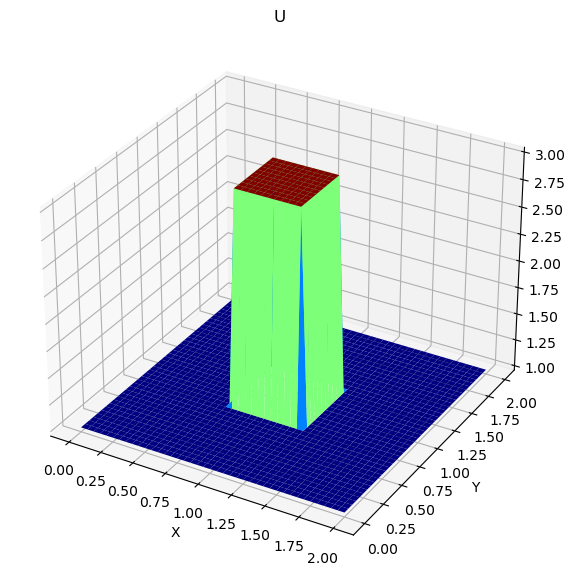

In [179]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = plt.subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, u[:], cmap=cm.jet)
plt.title('U')
plt.xlabel('X')
plt.ylabel('Y')
#fig.savefig('U-I.C.png', bbox_inches='tight')

Loop through the number of time steps. The implementation below uses regular `for` loops. An implementation using implicit loops is also done in the next section:

In [180]:
%%timeit -r 1 -n 1

for n in range(nt):  # time
    un = u.copy()
    vn = v.copy()

    for i in range(1, nx - 1):
        for j in range(1, ny - 1):
            u[i, j] = (
                un[i, j]
                - dt / dx * un[i, j] / 2 * (un[i + 1, j] - un[i - 1, j])
                - dt / dy * vn[i, j] / 2 * (un[i, j + 1] - un[i, j - 1])
                + dt / (dx**2) * nu  * (un[i + 1, j] - 2 * un[i, j] + un[i - 1, j])
                + dt / (dx**2) * nu  * (un[i, j + 1] - 2 * un[i, j] + un[i, j - 1])
            )

            v[i, j] = (
                vn[i, j]
                - dt / dx * un[i, j] / 2 * (vn[i + 1, j] - vn[i - 1, j])
                - dt / dy * vn[i, j] / 2 * (vn[i, j + 1] - vn[i, j - 1])
                + dt / (dx**2) * nu * (vn[i + 1, j] - 2 * vn[i, j] + vn[i - 1, j])
                + dt / (dx**2) * nu * (vn[i, j + 1] - 2 * vn[i, j] + vn[i, j - 1])
            )

            # Stores the result for each time step.
            # Allows retrieving intermediate results after processing.
            uf[n, i, j] = u[i, j]  # U in every time-step
            vf[n, i, j] = v[i, j]  # V in every time-step

    # Velocity boundary conditions
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1

    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1

6.48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Plotting the U field as a surface, showing the last iteration:

Text(0.5, 0.5, 'Y')

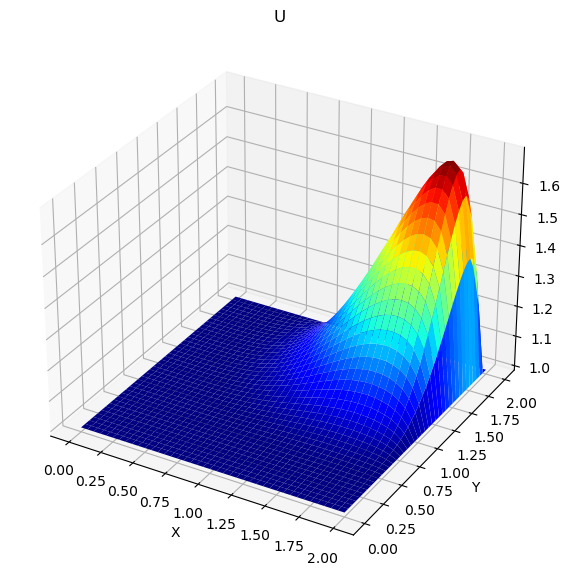

In [181]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = plt.subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, uf[-1], cmap=cm.jet, rstride=1, cstride=1)
plt.title('U')
plt.xlabel('X')
plt.ylabel('Y')
#fig.savefig('U.png', bbox_inches='tight')

---

## Implementation using implicit loops from the NumPy library

In [235]:
%%timeit -r 1 -n 1

for n in range(nt):  # time
    un = u.copy()
    vn = v.copy()

    u[1:-1, 1:-1] = ( un[1:-1, 1:-1]
        - dt / dx * un[1:-1, 1:-1] / 2 * (un[2:, 1:-1] - un[:-2, 1:-1])
        - dt / dy * vn[1:-1, 1:-1] / 2 * (un[1:-1, 2:] - un[1:-1, :-2])
        + nu * dt / dx**2 * (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1])
        + nu * dt / dy**2 * (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) )

    v[1:-1, 1:-1] = ( vn[1:-1, 1:-1]
        - dt / dx * un[1:-1, 1:-1] / 2 * (vn[2:, 1:-1] - vn[:-2, 1:-1])
        - dt / dy * vn[1:-1, 1:-1] / 2 * (vn[1:-1, 2:] - vn[1:-1, :-2])
        + nu * dt / dx**2 * (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1])
        + nu * dt / dy**2 * (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) )

    # Stores the result for each time step.
    # Allows retrieving intermediate results after processing.
    uf[n, :, :] = u[:, :]  # U in every time-step
    vf[n, :, :] = v[:, :]  # V in every time-step

    # Velocity boundary conditions
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1

    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1

90.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Show the result

Text(0.5, 0.5, 'Y')

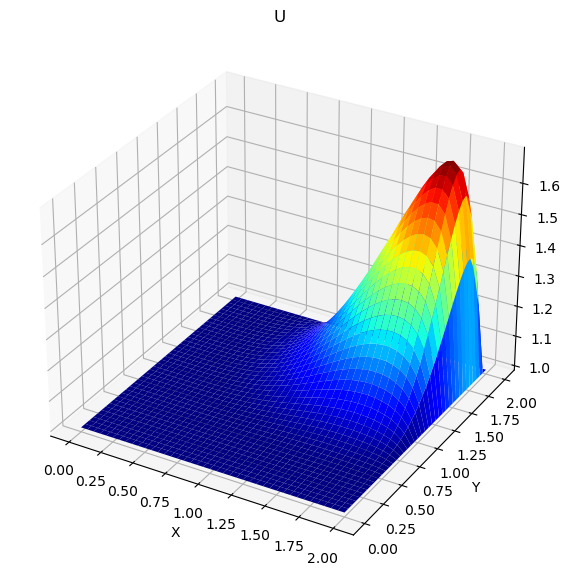

In [236]:
fig = plt.figure(figsize=(11, 7), dpi=100)
ax = plt.subplot(projection='3d')
X, Y = np.meshgrid(x, y)
ax.plot_surface(X, Y, uf[499], cmap=cm.jet, rstride=1, cstride=1)
plt.title('U')
plt.xlabel('X')
plt.ylabel('Y')
#fig.savefig('U.png', bbox_inches='tight')

## Conclusion

This work tried to show a little of the Burgers equation that is used to describe several types of phenomena, and the corresponding implementation using an example and plotting the result. The equations used came from the work of Kweyu et al. (2012). The example results showed the initial condition, and the result after a simulation with 500 iterations.

## References

Bahadır, A. R. (2003). A fully implicit finite-difference scheme for two-dimensional Burgers’ equations. *Applied Mathematics and Computation*, 137(1), 131–137. <https://doi.org/10.1016/S0096-3003(02)00091-7>

Barba, L. A., & Forsyth, G. F. (2018). CFD Python: The 12 steps to Navier-Stokes equations. *Journal of Open Source Education*, 2(16), 21. <https://doi.org/10.21105/jose.00021>

Costa-Junior, R. A., Rosa, R. R., Mattedi, A. P., & Ramos, F. M. (2004). Gradient pattern analysis of extended convection–diffusion. *Physica A: Statistical Mechanics and Its Applications*, 344(3–4), Article 3–4. <https://doi.org/10.1016/j.physa.2004.06.013>

Kweyu, M. C., Manyonge, W. A., Koross, A., & Ssemaganda, V. (2012). Numerical solutions of the Burgers’ system in two dimensions under varied initial and boundary conditions. <https://www.researchgate.net/publication/263100026>

Wang, Y., Navon, I. M., Wang, X., & Cheng, Y. (2016). 2D Burgers Equations with Large Reynolds Number Using POD/DEIM and Calibration. <https://doi.org/10.1002/fld.4249>

Zarzur, A. M., Stephany, S., Freitas, S. R. de, & Velho, H. F. de C. (2018). Numerical Experiments for Time Integration of 2D Burgers’ Equations. *Proceeding Series of the Brazilian Society of Computational and Applied Mathematics*, 6(1), Article 1. <https://proceedings.sbmac.org.br/sbmac/article/view/2025>
